<a href="https://colab.research.google.com/github/AeMcRa/Datascience-things/blob/main/AedaRamoU7proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install git+https://github.com/pydata/xarray.git
!pip install bambi
!pip install preliz

  Cloning https://github.com/pydata/xarray.git to /tmp/pip-req-build-a31fff44
  Running command git clone --filter=blob:none --quiet https://github.com/pydata/xarray.git /tmp/pip-req-build-a31fff44
  Resolved https://github.com/pydata/xarray.git to commit 0184702f16c3f744fc9096c7dac690626dcc6922
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [14]:
import preliz as pz
import numpy as np
import pymc as pm
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import xarray as xr
import bambi as bmb

# Predicting Positive Steam Ratings but Again and Better

As stated last time:
Steam is one of the largest computer game marketplaces, and since I make video games, it is useful to have information on how various components impact public perception and sales.

Since a lot of data on sales is proprietary, I only have a few factors to go off of, those being avg playtime, median playtime, price, and estimated owners(catagorical). Note that this is data from 2019, and is likely outdated. Smaller, low-mid priced games have seen a meteoric rise as of late, and this is likely not reflected in the data here.

Last time, I modeled positive rating percentage of steam games primarily based off of price and median playtime, This had a few issues. Median playtime is simply a wildly disparate metric that is not controllable at all, and is very genre-dependant. One could have the best single player game of all time, and it's median playtime would still be beat out by a mediocre online multiplayer game. Since price is controllable, I think it is a better metric to primarily base my analysis off of.

In my previous project, I also noticed that there were a few datapoints with prices upwards of 80-160, which tend not to be actual games, and also make the data harder to read. As we will see momentarily, I have pruned my data down to price points below 61 dollars, as most AAA (industry) games tend to cap out at 60 dollars (note that this data is from before the recent price hike to 70 dollar AAA games)

With the Gaussian-like processes, I hope to identify the subtrends within the popularity data that correspond with price brackets.

In [41]:
steam = pd.read_csv('https://raw.githubusercontent.com/AeMcRa/Datascience-things/refs/heads/main/steam3.csv')

In [42]:
steam

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,pos_percentage
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19,0.973888
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99,0.839787
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99,0.895648
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99,0.826623
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99,0.947996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,1065230,Room of Pandora,2019-04-24,1,SHEN JIAWEI,SHEN JIAWEI,windows,0,Single-player;Steam Achievements,Adventure;Casual;Indie,Adventure;Indie;Casual,7,3,0,0,0,0-20000,2.09,1.000000
27071,1065570,Cyber Gun,2019-04-23,1,Semyon Maximov,BekkerDev Studio,windows,0,Single-player,Action;Adventure;Indie,Action;Indie;Adventure,0,8,1,0,0,0-20000,1.69,0.888889
27072,1065650,Super Star Blast,2019-04-24,1,EntwicklerX,EntwicklerX,windows,0,Single-player;Multi-player;Co-op;Shared/Split ...,Action;Casual;Indie,Action;Indie;Casual,24,0,1,0,0,0-20000,3.99,0.000000
27073,1066700,New Yankee 7: Deer Hunters,2019-04-17,1,Yustas Game Studio,Alawar Entertainment,windows;mac,0,Single-player;Steam Cloud,Adventure;Casual;Indie,Indie;Casual;Adventure,0,2,0,0,0,0-20000,5.19,1.000000


In [43]:
steam = steam.query('(positive_ratings+negative_ratings) > 5.0')
steam = steam.query('price<61')
steam.shape

(22786, 19)

(array([5.300e+01, 1.000e+00, 0.000e+00, 0.000e+00, 4.000e+00, 2.000e+00,
        4.000e+00, 1.700e+01, 6.000e+00, 2.000e+00, 8.000e+00, 1.900e+01,
        2.800e+01, 1.900e+01, 4.300e+01, 2.000e+01, 5.700e+01, 1.400e+01,
        2.500e+01, 1.500e+01, 4.900e+01, 3.100e+01, 4.800e+01, 3.500e+01,
        2.300e+01, 7.900e+01, 4.600e+01, 6.900e+01, 8.800e+01, 3.500e+01,
        7.900e+01, 6.400e+01, 4.000e+01, 2.070e+02, 7.200e+01, 7.300e+01,
        9.900e+01, 1.330e+02, 1.180e+02, 7.000e+01, 1.550e+02, 1.180e+02,
        1.850e+02, 1.070e+02, 1.530e+02, 1.620e+02, 1.620e+02, 1.410e+02,
        1.370e+02, 7.700e+01, 4.670e+02, 1.410e+02, 1.640e+02, 1.970e+02,
        2.110e+02, 2.340e+02, 1.940e+02, 3.050e+02, 2.440e+02, 1.620e+02,
        3.100e+02, 2.800e+02, 3.350e+02, 2.730e+02, 2.900e+02, 2.520e+02,
        5.850e+02, 2.450e+02, 3.750e+02, 4.330e+02, 3.250e+02, 4.370e+02,
        4.080e+02, 3.830e+02, 2.890e+02, 5.330e+02, 4.210e+02, 4.520e+02,
        4.190e+02, 3.220e+02, 6.100e+0

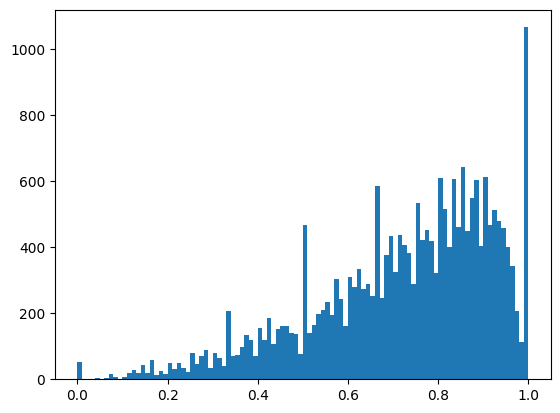

In [44]:
plt.hist(steam.pos_percentage,bins = 100)

# Histogram Analysis
Once again, we see the same sort of shape right-skewed shape with large spikes at regular values (ex: 1.0, 0.5, 0.33, 0.66, etc) This seems to be relatively standard for this data. We could remove this spike by culling the data with few ratings, but that would be mostly removing smaller games, which are what I'm focusing on this time.

# The First Model
I decided to start with a Bspline, in hopes that it would be able to better demonstrate how the data behaves at the lower bounds. I implimented the predictors and such in a similar manner to my previous models from last time.

In [65]:
num_knots = 2
knots = np.linspace(0, 61, num_knots+2)[1:-1]
model_spline = bmb.Model("pos_percentage ~ bs(price, degree=3, knots=knots)|owners + bs(median_playtime, degree=3, knots=knots) +bs(average_playtime, degree=3, knots=knots) ", steam)
idata_spline = model_spline.fit(idata_kwargs={"log_likelihood":True})

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


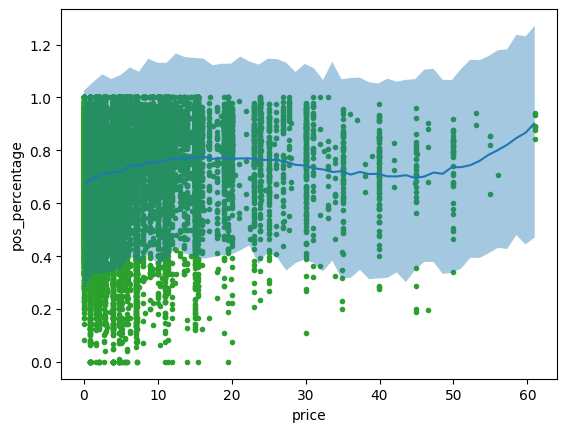

In [66]:
bmb.interpret.plot_predictions(model_spline, idata_spline, "price", pps= True)
plt.plot(steam.price, steam.pos_percentage, "C2.", zorder=-3)

# Analysis
From the graph, we see that at the lower price brackets, ratings tend to rise as the price approaches 20, then begin to fall off. This makes sense, as many quality indie games, as well as many older AAA games price themselves around the 15-20 dollar mark. Above that, you have the mid budget AA games which generally tend to be decent. At $60, you have modern AAA games, which *generally* tend to be well recieved, explaining the upturn at this point. Once thing that is particularily surprising to me is that there aren't more games at this price point, but that is probably the dataset's fault. These games are likely more proprietary and thus harder for the data mining people to get data on.

# Next Model
Next I will use a Hibert Space Gaussian Process. This model is pretty much only using price as a predictor, cause otherwise it would take 10000 years to run.

In [47]:
def get_ig_params(x_vals, l_b=None, u_b=None, mass=0.96, plot=False):
    """
    Returns a weakly informative prior for the length-scale parameter of the GP kernel.
    """

    differences = np.abs(np.subtract.outer(x_vals, x_vals))
    if l_b is None:
        l_b = np.min(differences[differences != 0]) * 2
    if u_b is None:
        u_b = np.max(differences) / 1.5

    dist = pz.InverseGamma()
    pz.maxent(dist, l_b, u_b, mass, plot=plot)

    return dict(zip(dist.param_names, dist.params))

In [48]:
pos_percentage = steam["pos_percentage"].values
price = steam["price"].values[:,None]

In [49]:
prior_gp = {
    "sigma": bmb.Prior("Gamma", mu=1, sigma=0.01),
    "ell": bmb.Prior("InverseGamma", **get_ig_params(price))
}

priors = {
    "hsgp(price, m=10, c=1.5)": prior_gp,
    "alpha": bmb.Prior("HalfNormal", sigma=1)
}

model_hsb = bmb.Model("pos_percentage ~ 0 + hsgp(price, m=10, c=1.5)", steam, priors=priors)
idata_hsb = model_hsb.fit(target_accept = 0.95)

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


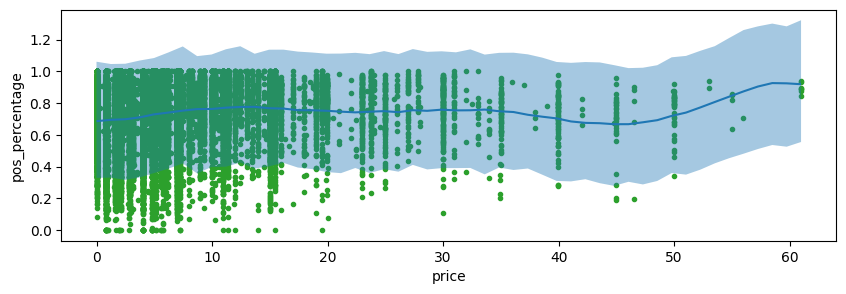

In [50]:
_, ax = bmb.interpret.plot_predictions(model_hsb, idata_hsb, ["price"],
                                       pps = True,
                                       fig_kwargs={"figsize": (10, 3)})
ax[0].plot(steam["price"].values, steam["pos_percentage"].values, "C2.",zorder = -2)

# Analysis
For the HSGP we see the same sort of general trend as with the bspline, though it does seem a bit more dampened. With this model, we can see that public perception increases up to around 12 dollars, then begins to fall off, and falls of more severely around 35 dollars. The lack of data around the 60 dollar price point stands out even more now.

Lets do a bit of comparison between the two models, as well as the models from last time.

In [57]:
model_steam = bmb.Model("pos_percentage ~  average_playtime + median_playtime+ owners + price", data=steam)

In [59]:
idata_steam = model_steam.fit(idata_kwargs={"log_likelihood":True})

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


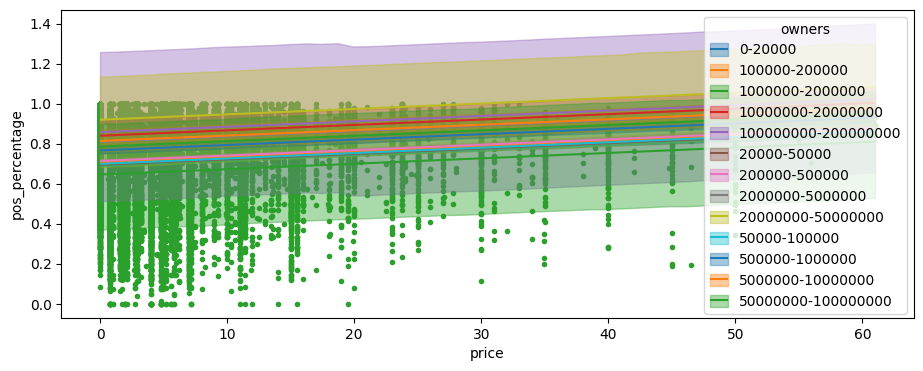

In [60]:
bmb.interpret.plot_predictions(model_steam,
                               idata_steam,
                                ["price",  "owners"], fig_kwargs={"figsize":(11, 4)})
plt.plot(steam.price, steam.pos_percentage, "C2.", zorder=-3)

In [61]:
model_steam_h = bmb.Model("pos_percentage ~  average_playtime + median_playtime + (price|owners)", data=steam)

In [62]:
idata_steam_h = model_steam_h.fit(idata_kwargs={"log_likelihood":True})

Output()

ERROR:pymc.stats.convergence:There were 20 divergences after tuning. Increase `target_accept` or reparameterize.


/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


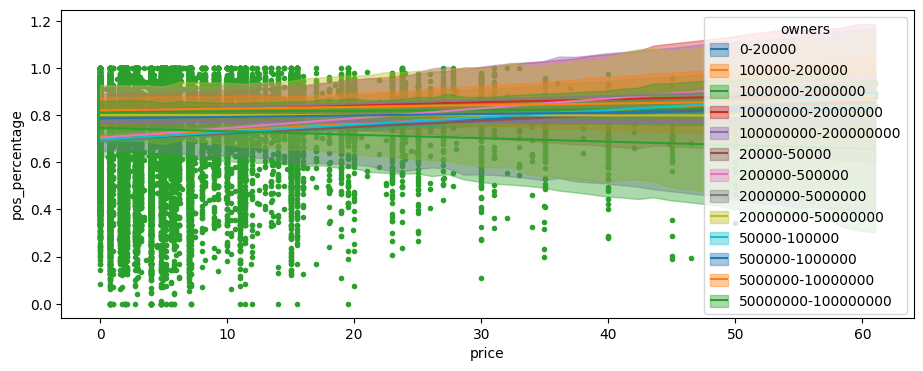

In [63]:
bmb.interpret.plot_predictions(model_steam_h,
                               idata_steam_h,
                                ["price",  "owners"], fig_kwargs={"figsize":(11, 4)})
plt.plot(steam.price, steam.pos_percentage, "C2.", zorder=-3)

In [67]:
cmp_bmb = az.compare( {"Bspline":idata_spline,"CatagoricalPrice":idata_steam,"HeirarchicalPrice":idata_steam_h} )
cmp_bmb

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Bspline,0,4612.967833,5.278705,0.000000,6.082666e-01,115.833832,0.000000,False,log
HeirarchicalPrice,1,4575.429161,14.639679,37.538672,3.917334e-01,114.082204,18.173555,False,log
CatagoricalPrice,2,4568.775838,11.590353,44.191995,1.110223e-16,114.096719,18.253538,True,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

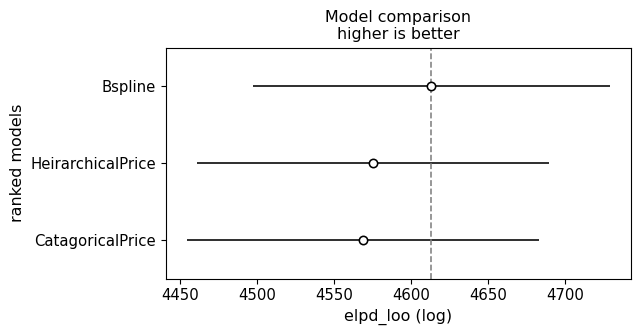

In [69]:
az.plot_compare(cmp_bmb)

<Axes: xlabel='pos_percentage'>

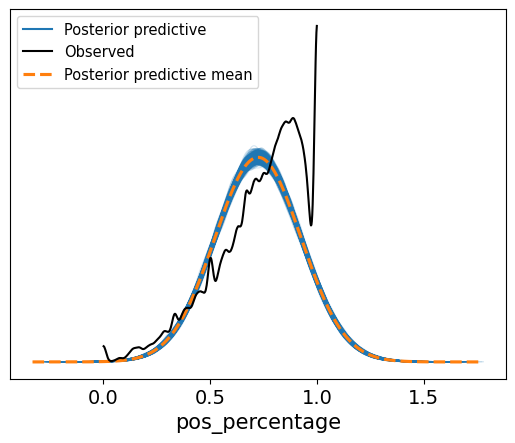

In [68]:
model_spline.predict(idata_spline,kind = "response")
az.plot_ppc(idata_spline)

<Axes: xlabel='pos_percentage'>

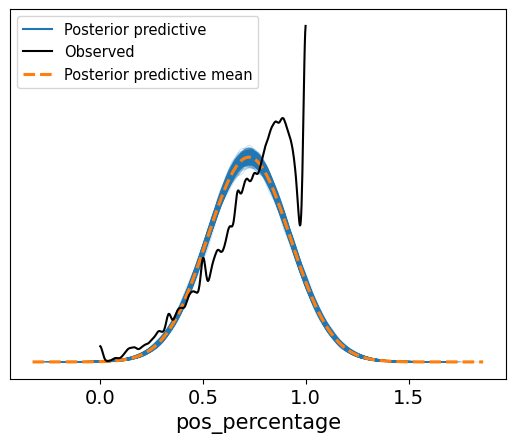

In [56]:
model_hsb.predict(idata_hsb,kind = "response")
az.plot_ppc(idata_hsb)

# Final Analysis and Conclusions

I think that the models from this project were definitly more informative than those from last project. In the last project, all that was available was general trends, but from this model, we can see the games market exists in price brackets.

From comparing the bspline and the HSGP, we can definitly see that the HSGP is a more 'dampened' version, but the data for both is generally pretty flat, so it makes sense that we have wide normal distributions.

In conclusion, we see that price trends are a lot more based in price bracket than last project's model would suggest. The lack of games around the 60 dollar price point strikes me as odd, so if I were to do a project on a similar topic, I would get more updated data. I think you can request data from SteamDB as a student, so perhaps I will look into that.